In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tqdm import tnrange, tqdm_notebook


from nupic.encoders import ScalarEncoder
from nupic.research.spatial_pooler import SpatialPooler
from nupic.research.temporal_memory import TemporalMemory
from nupic.algorithms.anomaly import Anomaly
from nupic.algorithms.sdr_classifier import SDRClassifier

%matplotlib inline

In [3]:
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt

Continuing in background, pid 24640.
Output will be written to ‘wget-log.1’.


In [4]:
df = pd.read_csv('sunspots.txt', sep='\t', names=['Months', 'SunSpots'], header=None, index_col='Months')

In [5]:
df.head()

,SunSpots
Months,
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


<h1>NuPIC</h1>
<p>For this example, we will try to implement nupic pipeline using barebone classes. The goal is to forecast anomalies from the given dataset. We will be using the sunspots per month dataset that you can get <a href="http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt" target="_blank">here</a></p>
<p>The NuPIC pipeline looks like this:</p>
<ul>
<li>Encoding data into SDR using Encoders</li>
<li>Passing encoded data through the Spatial Pooler</li>
<li>Running Temporal Memory over the Spatial Pooler’s active columns</li>
<li>Extracting predictions using a Classifier</li>
<li>Extracting anomalies using Anomaly and AnomalyLikelihood</li>
</ul>

<h1>Encoder</h1>
<p>Firstly, we need to set up an encoder. Since we have a limited set of data, we will be using ScalarEncoder. We could have also gone for the AdaptiveScalarEncoder, and the only difference between the two is that AdaptiveScalarEncoder doesn't need to know the min and max values of your data</p>
<p>When creating a Scalar Encoder, we need to supply it the following parameters.</p>
<dl>
  <dt>w</dt>
  <dd>The number of bits that are set to encode a single value in the output (applied to 0s and 1s). How many 1's you are going to get. w has to be an odd number greater than 21</dd>
  <dt>minval</dt>
  <dd>Minimal value in your dataset</dd>
  <dt>maxval</dt>
  <dd>Maximum value in your dataset</dd>
  <dt>periodic</dt>
  <dd>If true, then the input value "wraps around" such that minval=maxval, basically imagine a sin() function.</dd>
  <dt>n</dt>
  <dd>Total length of the output, aka number of columns. For example, if you have a layer 32x32, n=32^2</dd>
  <dt>radius</dt>
  <dd>Applies to input. Two inputs separated by more than the radius have
                 non-overlapping representations. Two inputs separated by less
                 than the radius will in general overlap in at least some of
                 their bits. You can think of this as the radius of the input. Default is 0. What this means, is that if you have a radius of 2: 2,4,8, etc will not share any bits</dd>
  <dt>resolution</dt>
  <dd>Applies to input. Two inputs separated by greater than, or equal to the resolution are guaranteed to have different representations. For example, with resolution=1, 1 and 2 will have different representation, but not 1 and 1.5. Default is 0.</dd>
  <dt>name</dt>
  <dd>Name of the encoder</dd>
  <dt>verbosity</dt>
  <dd>How much info to output: 0, 1, 2</dd>
  <dt>clipInput</dt>
  <dd>If true, non-periodic inputs smaller than minval or greater than maxval will be clipped to minval/maxval</dd>
  <dt>forced</dt>
  <dd>Skip safety checks</dd>
</dl>
<p>Some formuals</p>
<ul>
    <li>Range: $range = maxval - minval$</li>
     <li>Half-width: $h = (w-1)/2$  </li>
     <li>Resolution: $resolution = radius / w$</li>
     <li>Output length for periodic input: $n = w * range/radius$ or $n=w^2 * range * resolution$</li>
     <li>Output length for non-periodic input: $n = w * range/radius + 2 * h$</li>
</ul>
<p>As you can see, n, resolution and radius are mutually dependant. Hence, you can only provide one of those.</p>
<p>To learn more about encoders, read the <a href="http://nupic.docs.numenta.org/latest/encoders.html" target="_blank">official documentation</a> and watch HTM School episodes <a href="https://www.youtube.com/playlist?list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9" target="_blank">0, 1, 2, 3, 4, 5, 6</a></p>

Let's create a scalar encoder with w=21 and n=100

In [6]:
enc = ScalarEncoder(
    w=21, 
    minval=df.min().values, 
    maxval=df.max().values, 
    periodic=False, 
    n=125, 
    #radius=0, 
    #resolution=1, 
    name="sunspots", 
    verbosity=0, 
    clipInput=False, 
    forced=False)

<h1>Spatial Pooler</h1>
<p>Now that we have an encoder, let's set up a Spatial Pooler. The most fundamental function of the spatial pooler is to convert a region’s input into a sparse pattern. This function is important because the mechanism used to learn sequences and make predictions requires starting with sparse distributed patterns.</p>
<p>Spatial Pooler supports the following hyperparameters:</p>
<dl>
  <dt>inputDimensions</dt>
  <dd>A sequence representing the dimensions of the input vector. Format is
      (height, width, depth, ...)</dd>
  <dt>columnDimensions</dt>
  <dd>A sequence representing the dimensions of the columns in the region.
      Format is (height, width, depth, ...), where each value represents the
      size of the dimension.  For a topology of one dimension with 2000 columns
      use 2000, or (2000,). For a three dimensional topology of 32x64x16 use
      (32, 64, 16).</dd>
  <dt>potentialRadius</dt>
  <dd>This parameter determines the extent of the input that each column can
      potentially be connected to.  This can be thought of as the input bits
      that are visible to each column, or a 'receptiveField' of the field of
      vision. A large enough value will result in 'global coverage', meaning
      that each column can potentially be connected to every input bit. This
      parameter defines a square (or hyper
      square) area: a column will have a max square potential pool with sides of
      length $2 * potentialRadius + 1$.</dd>
  <dt>potentialPct</dt>
  <dd>The percent of the inputs, within a column's potential radius, that a
      column can be connected to.  If set to 1, the column will be connected
      to every input within its potential radius. This parameter is used to
      give each column a unique potential pool when a large potentialRadius
      causes overlap between the columns. At initialization time we choose
     $((2*potentialRadius + 1)^(# inputDimensions) * potentialPct)$ input bits
      to comprise the column's potential pool.</dd>
  <dt>globalInhibition</dt>
  <dd>If true, then during inhibition phase the winning columns are selected
      as the most active columns from the region as a whole. Otherwise, the
      winning columns are selected with respect to their local neighborhoods.
      Using global inhibition boosts performance x60. To learn more about inhibition and topology, watch this
      <a href="https://youtu.be/HTW2Q_UrkAw" target="_blank">HTM School</a> episode.
      </dd>
  <dt>localAreaDensity</dt>
  <dd>The desired density of active columns within a local inhibition area
      (the size of which is set by the internally calculated inhibitionRadius,
      which is in turn determined from the average size of the connected
      potential pools of all columns). The inhibition logic will insure that
      at most N columns remain ON within a local inhibition area, where
      $N = localAreaDensity * (total number of columns in inhibition area)$</dd>
  <dt>numActiveColumnsPerInhArea</dt>
  <dd>An alternate way to control the density of the active columns. If
      numActiveColumnsPerInhArea is specified then localAreaDensity must be
      less than 0, and vice versa.  When using numActiveColumnsPerInhArea, the
      inhibition logic will insure that at most 'numActiveColumnsPerInhArea'
      columns remain ON within a local inhibition area (the size of which is
      set by the internally calculated inhibitionRadius, which is in turn
      determined from the average size of the connected receptive fields of all
      columns). When using this method, as columns learn and grow their
      effective receptive fields, the inhibitionRadius will grow, and hence the
      net density of the active columns will *decrease*. This is in contrast to
      the localAreaDensity method, which keeps the density of active columns
      the same regardless of the size of their receptive fields.</dd>
  <dt>stimulusThreshold</dt>
  <dd>This is a number specifying the minimum number of synapses that must be
      on in order for a columns to turn ON. The purpose of this is to prevent
      noise input from activating columns. Specified as a percent of a fully
      grown synapse.</dd>
  <dt>synPermInactiveDec</dt>
  <dd>The amount by which an inactive synapse is decremented in each round.
      Specified as a percent of a fully grown synapse.</dd>
  <dt>synPermActiveInc</dt>
  <dd>The amount by which an active synapse is incremented in each round.
      Specified as a percent of a fully grown synapse.</dd>
  <dt>synPermConnected</dt>
  <dd>The default connected threshold. Any synapse whose permanence value is
      above the connected threshold is a "connected synapse", meaning it can
      contribute to the cell's firing.</dd>
  <dt>minPctOverlapDutyCycle</dt>
  <dd>A number between 0 and 1.0, used to set a floor on how often a column
      should have at least stimulusThreshold active inputs. Periodically, each
      column looks at the overlap duty cycle of all other columns within its
      inhibition radius and sets its own internal minimal acceptable duty cycle
      to: minPctDutyCycleBeforeInh * max(other columns' duty cycles).  On each
      iteration, any column whose overlap duty cycle falls below this computed
      value will  get all of its permanence values boosted up by
      synPermActiveInc. Raising all permanences in response to a sub-par duty
      cycle before  inhibition allows a cell to search for new inputs when
      either its previously learned inputs are no longer ever active, or when
      the vast majority of them have been "hijacked" by other columns.</dd>
  <dt>dutyCyclePeriod</dt>
  <dd>The period used to calculate duty cycles. Higher values make it take
      longer to respond to changes in boost or synPerConnectedCell. Shorter
      values make it more unstable and likely to oscillate.</dd>
  <dt>boostStrength</dt>
  <dd>A number greater or equal than 0.0, used to control the strength of
      boosting. No boosting is applied if it is set to 0. Boosting strength
      increases as a function of boostStrength. Boosting encourages columns to
      have similar activeDutyCycles as their neighbors, which will lead to more
      efficient use of columns. However, too much boosting may also lead to
      instability of SP outputs.</dd>
  <dt>seed</dt>
  <dd>Seed for our own pseudo-random number generator.</dd>
  <dt>spVerbosity</dt>
  <dd>spVerbosity level: 0, 1, 2, or 3</dd>
  <dt>wrapAround</dt>
  <dd>Determines if inputs at the beginning and end of an input dimension should
      be considered neighbors when mapping columns to inputs.</dd>
</dl>

<p>Let's create a SpatialPooler to match our encoder's output. Our input dimension must be of the same size as our output dimension (columnDimension), for example if input is (x, x) the output should be (y, y). Let's define out input dimension as (10, 10) to match n=100, and our output dimension to be a bit smaller, (5, 5) </p>


<p>To learn more about Spatial Poolers, read the <a href="http://numenta.com/assets/pdf/biological-and-machine-intelligence/0.4/BaMI-Spatial-Pooler.pdf" target="_blank">BAmL documentation</a> and watch HTM School episodes <a href="https://www.youtube.com/playlist?list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9" target="_blank">7, 8</a></p>

In [7]:
sp = SpatialPooler(
    inputDimensions=(5,25), #enc.encode(0).shape,
    columnDimensions=(5, 10),
    potentialRadius=16,
    potentialPct=0.5,
    globalInhibition=False,
    localAreaDensity=-1.0,
    numActiveColumnsPerInhArea=10.0,
    stimulusThreshold=0,
    synPermInactiveDec=0.008,
    synPermActiveInc=0.05,
    synPermConnected=0.10,
    minPctOverlapDutyCycle=0.001,
    dutyCyclePeriod=1000,
    boostStrength=0.0,
    seed=-1,
    spVerbosity=0,
    wrapAround=True
)

Also, in order to use SpatialPooler we need to create an array whose size is equal to the number of columns, where SP will store its output.

In [8]:
active_array = np.zeros(np.prod(sp.getColumnDimensions()))

<h1>Temporal Memory</h1>
<p>Next step is Temporal Memory. </p>
<dl>
  <dt>columnDimensions</dt>
  <dd>Dimensions of the column space</dd>
  <dt>cellsPerColumn</dt>
  <dd>Number of cells per column</dd>
  <dt>activationThreshold</dt>
  <dd>If the number of active connected synapses on a segment is at least this
    threshold, the segment is said to be active.</dd>
  <dt>initialPermanence</dt>
  <dd>Initial permanence of a new synapse</dd>
  <dt>connectedPermanence</dt>
  <dd>If the permanence value for a synapse is greater than this value, it is said
    to be connected.</dd>
  <dt>minThreshold</dt>
  <dd>If the number of potential synapses active on a segment is at least this
    threshold, it is said to be "matching" and is eligible for learning.</dd>
  <dt>maxNewSynapseCount</dt>
  <dd>The maximum number of synapses added to a segment during learning.</dd>
  <dt>permanenceIncrement</dt>
  <dd>Amount by which permanences of synapses are incremented during learning.</dd>
  <dt>permanenceDecrement</dt>
  <dd>Amount by which permanences of synapses are decremented during learning.</dd>
  <dt>predictedSegmentDecrement</dt>
  <dd>Amount by which segments are punished for incorrect predictions.</dd>
  <dt>maxSegmentsPerCell</dt>
  <dd>The maximum number of segments per cell.</dd>
  <dt>maxSynapsesPerSegment</dt>
  <dd>The maximum number of synapses per segment.</dd>
  <dt>seed</dt>
  <dd>Seed for the random number generator.</dd>  
</dl>
<p>Let's initialize a TM with column dimensions 50x50 and depth 5. The workflow of TM is following: we feed it active indices calculated by SP and get TM.</p>
<p>To learn more about TemporalMemory, check out HTM School <a href="https://youtu.be/UBzemKcUoOk">episode 11</a>, 

In [9]:
tm = TemporalMemory(
    columnDimensions=(50,50),
    cellsPerColumn=5,
    activationThreshold=13,
    initialPermanence=0.21,
    connectedPermanence=0.50,
    minThreshold=10,
    maxNewSynapseCount=20,
    permanenceIncrement=0.10,
    permanenceDecrement=0.10,
    predictedSegmentDecrement=0.0,
    maxSegmentsPerCell=255,
    maxSynapsesPerSegment=255,
    seed=42
)

<h1>Anomaly Detector</h1>
<p>The following params are available</p>
<dl>
  <dt>slidingWindowSize</dt>
  <dd>how many elements are summed up;
      enables moving average on final anomaly score</dd>
  <dt>mode</dt>
  <dd>how to compute anomaly: 'pure' - raw anomaly score, 'likelihood' - probability of receiving this value and anomalyScore, 'weighted' - multiplies the likelihood result with the raw anomaly score that was used to
  generate the likelihood </dd>
  <dt>binaryAnomalyThreshold</dt>
  <dd>if set [0,1] anomaly score
       will be discretized to 1/0 (1 if >= binaryAnomalyThreshold)
       The transformation is applied after moving average is computed</dd>
</dl>


In [10]:
anomaly = Anomaly(
    slidingWindowSize=None,
    mode='pure',
    binaryAnomalyThreshold=None
)

<h1>SDR Classifier</h1>
<p>Classifier is used not only to predict labels, but to perform regression as well. After initializing the classifier, we need to fit it a very particular pattern of data, which it learns and outputs predicted labels. The reason for such peculiar behavior is that its not possible to decode outputs from Spatial Poolers and Temporal Memory back into SDR.</p>
<p>To initalize the classifier, you can use the following parameters:</p>
<dl>
  <dt>steps</dt>
  <dd>Sequence of the different steps of multi-step predictions to learn</dd>
  <dt>alpha</dt>
  <dd>The alpha used to adapt the weight matrix during learning. A larger alpha results in faster adaptation to the data.</dd>
  <dt>actValueAlpha</dt>
  <dd>Used to track the actual value within each bucket. A lower actValueAlpha results in longer term memory</dd>
  <dt>verbosity</dt>
  <dd>verbosity: 0, 1, 2</dd>
</dl>
<p>In order to get the prediction for the next variable, we need to train it with the following data by calling compute method</p>
<dl>
  <dt>recordNum</dt>
  <dd>Record number of this input pattern. Record numbers normally increase sequentially by 1 each time unless there are missing records in the dataset. Knowing this information insures that we don’t get confused by missing records.</dd>
  <dt>patternNZ</dt>
  <dd>List of the active indices from the output below. When the input is from TemporalMemory, this list should be the indices of the active cells.</dd>
  <dt>classification</dt>
  <dd>Dict of the classification information where:
<ul>
<li> bucketIdx: index of the encoder bucket, could be obtained by calling getBucketIndices from encoder</li>
<li>actValue: actual value going into the encoder</li>
<li>Classification could be None for inference mode.</li>
</ul>
</dd>
  <dt>learn</dt>
  <dd>if true, learn this sample</dd>
  <dt>infer</dt>
  <dd>if true, perform inference</dd>
</dl>
<p>If you just want to do inference, you can call inference method</p>
<p>Both methods return the following:</p>

In [11]:
classifier = SDRClassifier(steps=[1], alpha=0.1, actValueAlpha=0.1, verbosity=0)

Now, let's push some data through our pipeline and see how it goes

In [12]:
anomaly_scores = []
predictions = []
next_t_columns = [] # temp column to keep previous predicted columns

In [13]:
for x in tqdm_notebook(xrange(df.shape[0])):
    sp.compute(inputVector=enc.encode(df.values[x][0]), learn=True, activeArray=active_array)
    tm.compute(np.where(active_array == 1)[0])
    anomaly_score = anomaly.compute(activeColumns=tm.getActiveCells(), 
                   predictedColumns=next_t_columns)
    next_t_columns = tm.getPredictiveCells()
    cl_ = classifier.compute(
        recordNum=x,
        patternNZ=tm.getActiveCells(), 
        classification = {
            "bucketIdx": enc.getBucketIndices(df.values[x][0])[0], 
            "actValue": df.values[x][0]
        }, 
        learn=True, 
        infer=True
    )
    top_prediction = sorted(zip(cl_[1], cl_["actualValues"]), reverse=True)[0][1] # returns: likelihood, value
    anomaly_scores.append(anomaly_score)
    predictions.append(top_prediction)

In [14]:
df['Prediction'] = predictions

In [15]:
anomaly_threshold = 2
z_scores = np.abs((anomaly_scores - np.mean(anomaly_scores))/np.std(anomaly_scores, ddof=1))
anomalies = np.where(z_scores > anomaly_threshold)[0]

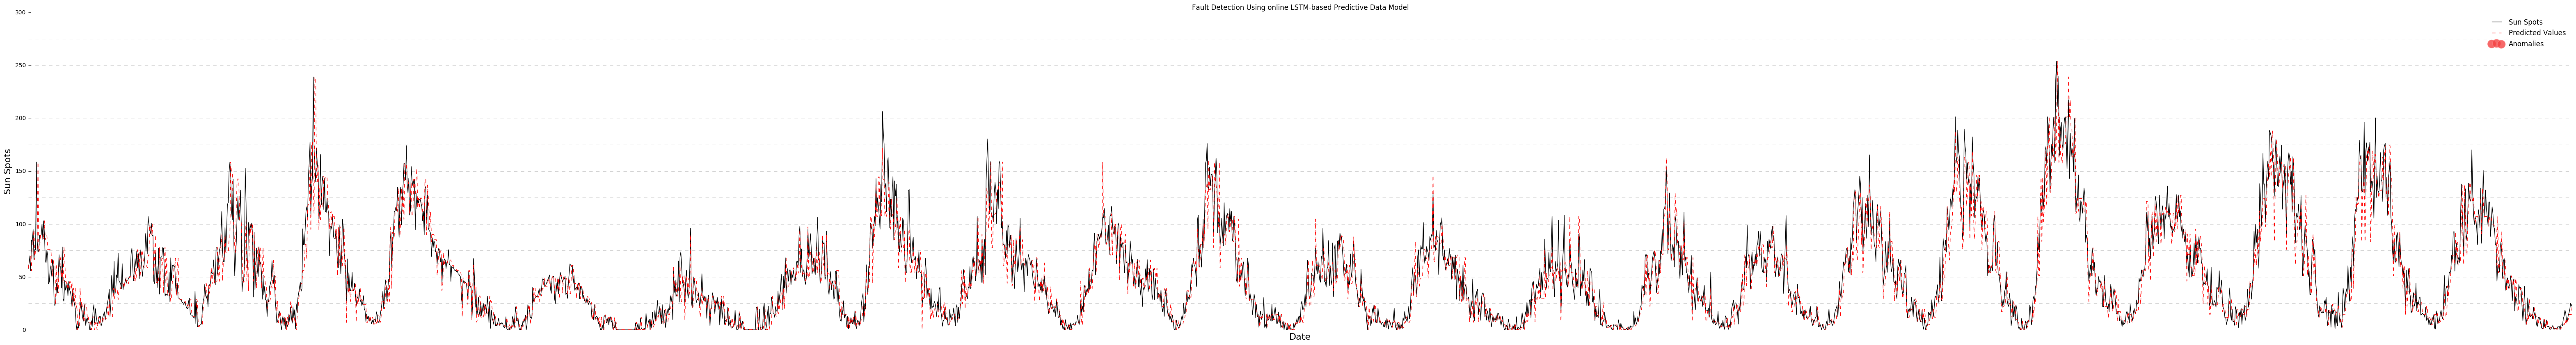

In [18]:
# Plot
fig = plt.figure(figsize=(80,10))
ax = plt.gca()

# Format Dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Remove Spines
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  

# Set ticks
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  

# Set X-limit
plt.xlim(df.iloc[0].name, df.iloc[-1].name)


# Draw horizontal lines
for y in xrange(0, 300, 25):    
    plt.plot((df.iloc[0].name, df.iloc[-1].name), (y, y), "--", lw=0.5, color="#333333", alpha=0.3) 

plt.xlabel("Date", fontsize=16)  
plt.ylabel("Sun Spots", fontsize=16)  
plt.title("Fault Detection Using online LSTM-based Predictive Data Model")
# Plot data
ax.plot(df['SunSpots'], 'k', label="Sun Spots")
ax.plot(df['Prediction'], 'r--', label="Predicted Values")
ax.scatter(df.ix[anomalies].index.values, 
           df.ix[anomalies]['SunSpots'].values, 
           edgecolors='#fc7e7e', facecolors='#f44242', label='Anomalies', lw=1, s=200, alpha=0.8)
ax.legend(frameon=False)
plt.savefig('NuPIC_Tutorial.png', format='png', dpi=300)